# Multi Task Model

## Imports

In [1]:
# Tensorflow imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import MobileNet
import numpy as np
import matplotlib.pyplot as plt

from loadData import createDataset

## Model parameters

In [2]:
# Log parameters
model_name = 'multiTaskModel_alt2'
savedModelPath = f'../../log/saved_models/{model_name}'
tb_log_dir = f'../../log/tensorboard/{model_name}'
cp_filepath = f'../../log/cps/{model_name}/latest_weights.h5'

# Dynamic hyperparameters
learningRate = 0.001
doDataAugmentation = True
doFineTuning = True
dropoutRate = 0.25
width_multiplier = 1
depth_multiplier = 1

# Training parameters
batch_size = 32
epochs = 20

## Model callbacks

In [3]:
callbacks = [
    # Checkpoint callback                    
    keras.callbacks.ModelCheckpoint(
                    filepath=cp_filepath, 
                    verbose=1, 
                    save_weights_only=True),

    # Tensorboard callback
    keras.callbacks.TensorBoard(log_dir=tb_log_dir, histogram_freq=1),

    # Early Stopping callback
    # keras.callbacks.EarlyStopping(
    #                 monitor="val_loss",
    #                 patience=2,
    #                 verbose=1)
]

## Data parameters

In [4]:
image_height = 160
image_width = 160

## Data Augmentation

In [5]:
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomRotation(0.1),
        keras.layers.RandomBrightness(0.2),
    ]
)

## Creating the training datasets

In [6]:
x, y_face, y_mask, y_age = createDataset('../../data/m3/training', (image_height, image_width))

## Creating the test dataset

In [7]:
#test_ds = createDataset('../../data/m3/training', batch_size, 0)

## Load the ResNet model

In [8]:
# Loading either the MobileNet architecture model or the previously saved model, and freeze it for transfer learning
mobilenet = MobileNet(
                input_shape=(image_height, image_width, 3), # Optional shape tuple, only to be specified if include_top is False
                alpha=width_multiplier, # Controls the width of the network. (Width multiplier)
                depth_multiplier=depth_multiplier, # Depth multiplier for depthwise convolution. (Resolution multiplier)
                dropout=dropoutRate, # Dropout rate. Default to 0.001.
                weights="imagenet",
                input_tensor=None,
                pooling='avg', # Optional pooling mode for feature extraction when include_top is False. (None, avg, max)
                include_top=False
                )
           
# Freeze the base model
mobilenet.trainable = False

inputs = keras.Input(shape=(image_height, image_width, 3))
# Data Augmentation on input
if(doDataAugmentation):
    inputs = data_augmentation(inputs)

# Running base model in inference mode
base_model = mobilenet(inputs, training=False)

## Creating Task 1 (Face Detection) Top Model

In [9]:
# Add Dense layer
face_head = tf.keras.layers.Dense(256)(base_model)
face_head = tf.keras.layers.Dense(128)(face_head)

# Final layer for binary classification
face_outputs = keras.layers.Dense(2, activation='softmax', name='face_output')(face_head)


## Creating Task 2 (Mask Detection) Top Model

In [10]:
# Add Dense layer
mask_head = tf.keras.layers.Dense(256)(base_model)
mask_head = tf.keras.layers.Dense(128)(mask_head)

# Final layer for binary classification
mask_outputs = keras.layers.Dense(2, activation='softmax', name='mask_output')(mask_head)

## Creating Task 3 (Age Prediction) Top Model

In [11]:
# Add Dense layer
age_head = tf.keras.layers.Dense(512)(base_model)
age_head = tf.keras.layers.Dense(256)(age_head)

# Final layer for binary classification
age_outputs = keras.layers.Dense(120, activation='softmax', name='age_output')(age_head)

## Creating and compiling the final model

In [12]:

model = keras.Model(inputs, [face_outputs, mask_outputs, age_outputs])
keras.utils.plot_model(model)

# Using a joint loss function for the three tasks:
# [ Loss = gamma * Loss_task1 + gamma * Loss_task2 + gamma * Loss_task3 ]
# Because every task is dependant on every other task, the model receives the loss of every task when gamma > 0

gamma = 1

model.compile(
      optimizer=keras.optimizers.Adam(0.001), # Learning Rate?
            loss={
                  'face_output': keras.losses.SparseCategoricalCrossentropy(), 
                  'mask_output': keras.losses.SparseCategoricalCrossentropy(),
                  'age_output': keras.losses.SparseCategoricalCrossentropy(ignore_class=-1)
                  },
            loss_weights={
                  'face_output': 0.33 * gamma, 
                  'mask_output': 0.33 * gamma,
                  'age_output': 0.33 * gamma
                  }, 
            metrics='accuracy',
)

model.summary()

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 mobilenet_1.00_160 (Functional  (None, 1024)        3228864     ['input_3[0][0]']                
 )                                                                                                
                                                                                                  
 dense (Dense)                  (None, 256) 

## Training the model with the dataset

In [13]:
history = model.fit(
            x,
            y={'face_output': y_face, 
             'mask_output': y_mask,
             'age_output': y_age},
            batch_size=batch_size,
            epochs=epochs, 
            callbacks=callbacks,
            validation_split=0.2,
            shuffle=True
        )

Epoch 1/20
512/512 [==============================] - ETA: 0s - loss: 1.4657 - face_output_loss: 0.0516 - mask_output_loss: 0.0488 - age_output_loss: 4.3411 - face_output_accuracy: 0.9931 - mask_output_accuracy: 0.9901 - age_output_accuracy: 0.0413
Epoch 1: saving model to ../../log/cps/multiTaskModel_alt2\latest_weights.h5
512/512 [==============================] - 115s 220ms/step - loss: 1.4657 - face_output_loss: 0.0516 - mask_output_loss: 0.0488 - age_output_loss: 4.3411 - face_output_accuracy: 0.9931 - mask_output_accuracy: 0.9901 - age_output_accuracy: 0.0413 - val_loss: nan - val_face_output_loss: 0.0051 - val_mask_output_loss: 1.1582e-05 - val_age_output_loss: nan - val_face_output_accuracy: 0.9980 - val_mask_output_accuracy: 1.0000 - val_age_output_accuracy: 0.0000e+00
Epoch 2/20
512/512 [==============================] - ETA: 0s - loss: 1.1707 - face_output_loss: 0.0057 - mask_output_loss: 0.0114 - age_output_loss: 3.5304 - face_output_accuracy: 0.9988 - mask_output_accuracy:

## Fine tuning

In [ ]:
if doFineTuning:
      model_name = model_name + '_ft'
      mobilenet.trainable = True
      model.summary()

      model.compile(
            optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
            loss={
                  'face_output': keras.losses.BinaryCrossentropy(), 
                  'mask_output': keras.losses.BinaryCrossentropy(),
                  'age_output': keras.losses.SparseCategoricalCrossentropy()
                  },
            loss_weights={
                  'face_output': gamma, 
                  'mask_output': gamma,
                  'age_output': gamma
                  }, 
                  metrics=['accuracy']
      )

      model.fit(training_ds, epochs=epochs)

## Save the model

In [ ]:
model.save(savedModelPath)

## Test model with test dataset

In [ ]:
results = model.evaluate(test_ds)

print(f'Loss: {results[0]}; Accuracy: {results[1]}')

## Predict new images

1/1 [==============================] - 0s 54ms/step
Face: [89.06096  10.939046]%
Mask: [9.9999390e+01 6.0637965e-04]%
Age: 61


Text(0.5, 1.0, 'Face: 10.94% | Mask: 0.00% | Age: 56')

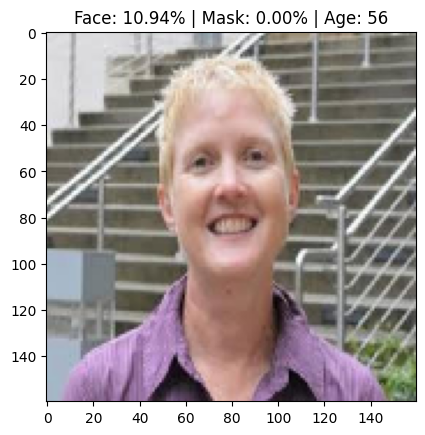

In [45]:
# https://www.tensorflow.org/tutorials/images/classification

img = tf.keras.utils.load_img(
    '../../data/m3/training/face/noMask/1_0_34_512938.jpg', target_size=(image_height, image_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array_batch = tf.expand_dims(img_array, 0) # Create a batch

preds = model.predict(img_array_batch)
age_output_indexes = np.array([i for i in range(0, 120)])
apparent_predictions = np.sum(preds[2][0] * age_output_indexes)

print(f"Face: {preds[0][0]*100}%")
print(f"Mask: {preds[1][0]*100}%")
print(f"Age: {np.argmax(preds[2][0])}")

ax = plt.subplot(1, 1, 1)
plt.imshow(img)
plt.title("Face: {:.2f}% | Mask: {:.2f}% | Age: {:.0f}".format(preds[0][0][1]*100, preds[1][0][1]*100, apparent_predictions))